# Forecasting COVID-19 with an LSTM. 
## Dataset from Kaggle:  
https://www.kaggle.com/c/covid19-global-forecasting-week-3 

In [0]:
#import libraries

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and inspect the  training data

In [0]:
train_df=pd.read_csv("train.csv")

In [34]:
train_df.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [35]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22950 entries, 0 to 22949
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              22950 non-null  int64  
 1   Province_State  9750 non-null   object 
 2   Country_Region  22950 non-null  object 
 3   Date            22950 non-null  object 
 4   ConfirmedCases  22950 non-null  float64
 5   Fatalities      22950 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.1+ MB


In [36]:
print(train_df[train_df["Province_State"]=="New York"])

          Id Province_State  ... ConfirmedCases Fatalities
19875  28356       New York  ...            0.0        0.0
19876  28357       New York  ...            0.0        0.0
19877  28358       New York  ...            0.0        0.0
19878  28359       New York  ...            0.0        0.0
19879  28360       New York  ...            0.0        0.0
...      ...            ...  ...            ...        ...
19945  28426       New York  ...        83948.0     1941.0
19946  28427       New York  ...        92506.0     2373.0
19947  28428       New York  ...       102987.0     2935.0
19948  28429       New York  ...       113833.0     3565.0
19949  28430       New York  ...       123160.0     4159.0

[75 rows x 6 columns]


In [0]:
train_df["days"]=[x for x in range(1,307) for x in range(1,76)]

In [38]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22950 entries, 0 to 22949
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              22950 non-null  int64  
 1   Province_State  9750 non-null   object 
 2   Country_Region  22950 non-null  object 
 3   Date            22950 non-null  object 
 4   ConfirmedCases  22950 non-null  float64
 5   Fatalities      22950 non-null  float64
 6   days            22950 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 1.2+ MB


In [0]:
# filter for state, to forecast for specific case --New York 
train_df=train_df[train_df["Province_State"] == "New York"]

In [40]:
train_df.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,days
19875,28356,New York,US,2020-01-22,0.0,0.0,1
19876,28357,New York,US,2020-01-23,0.0,0.0,2
19877,28358,New York,US,2020-01-24,0.0,0.0,3
19878,28359,New York,US,2020-01-25,0.0,0.0,4
19879,28360,New York,US,2020-01-26,0.0,0.0,5


In [41]:
x=train_df.iloc[:,1] # set the variable x for our label
x

19875    New York
19876    New York
19877    New York
19878    New York
19879    New York
           ...   
19945    New York
19946    New York
19947    New York
19948    New York
19949    New York
Name: Province_State, Length: 75, dtype: object

In [42]:
time=train_df.iloc[:,6] 
time.head()


19875    1
19876    2
19877    3
19878    4
19879    5
Name: days, dtype: int64

In [43]:
# set the y variable, which will be the # of confirmed cases
y=train_df.iloc[:,4]
y

19875         0.0
19876         0.0
19877         0.0
19878         0.0
19879         0.0
           ...   
19945     83948.0
19946     92506.0
19947    102987.0
19948    113833.0
19949    123160.0
Name: ConfirmedCases, Length: 75, dtype: float64

In [44]:
# turn the data into numpy arrays
time=time.to_numpy(dtype="float32")
series=y.to_numpy(dtype="float32")
time.shape

(75,)

Text(0.5, 0, 'Days')

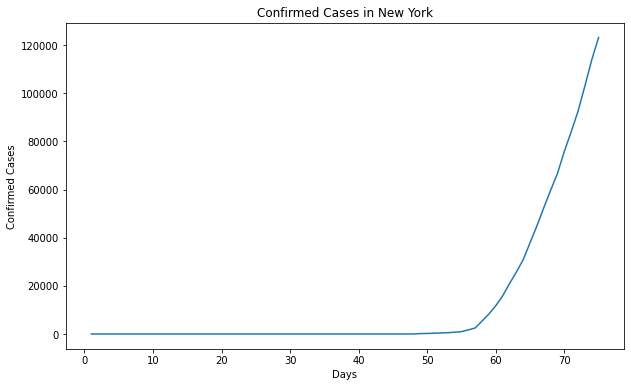

In [45]:
plt.figure(figsize=(10, 6))

plt.plot(time, series)
plt.title("Confirmed Cases in New York")
plt.ylabel("Confirmed Cases")
plt.xlabel("Days")

Split the training Set into training and Validation. Training set is until 70 days last 4 days will be predicted. The last 4 days will serve to select which method is the best for forecasting.

In [0]:
time=np.array(time)
series=np.array(series)
split_time = 71
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [0]:
window_size = 2
batch_size = 3
shuffle_buffer_size = 71

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  
  return dataset

In [0]:
dataset = windowed_dataset(x_train, window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

In [50]:
print(x_train)

[    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.   173.   220.
   328.   421.   525.   732.   967.  1706.  2495.  5365.  8310. 11710.
 15800. 20884. 25681. 30841. 37877. 44876. 52410. 59648. 66663. 75833.
 83948.]


In [51]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

model.compile(loss=tf.keras.losses.Huber(), optimizer="adam")
model.fit(dataset,epochs=100)

Epoch 1/100
23/23 [==============================] - 0s 3ms/step - loss: 3646.0322
Epoch 2/100
23/23 [==============================] - 0s 1ms/step - loss: 3476.8469
Epoch 3/100
23/23 [==============================] - 0s 1ms/step - loss: 3320.8669
Epoch 4/100
23/23 [==============================] - 0s 1ms/step - loss: 3156.4551
Epoch 5/100
23/23 [==============================] - 0s 1000us/step - loss: 3004.1018
Epoch 6/100
23/23 [==============================] - 0s 1ms/step - loss: 2840.5276
Epoch 7/100
23/23 [==============================] - 0s 1ms/step - loss: 2685.4004
Epoch 8/100
23/23 [==============================] - 0s 1ms/step - loss: 2550.0293
Epoch 9/100
23/23 [==============================] - 0s 1ms/step - loss: 2372.4834
Epoch 10/100
23/23 [==============================] - 0s 1ms/step - loss: 2231.9836
Epoch 11/100
23/23 [==============================] - 0s 1ms/step - loss: 2082.9792
Epoch 12/100
23/23 [==============================] - 0s 1ms/step - loss: 1939.214

[array([[96782.734]], dtype=float32), array([[106751.98]], dtype=float32), array([[118591.84]], dtype=float32), array([[131278.97]], dtype=float32)]
[array([[96782.734]], dtype=float32), array([[106751.98]], dtype=float32), array([[118591.84]], dtype=float32), array([[131278.97]], dtype=float32)]


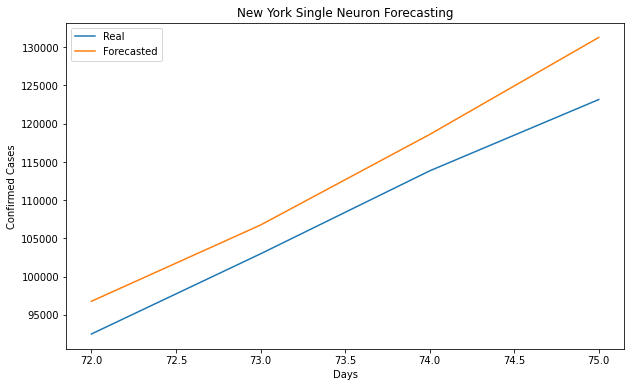

In [52]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
  

forecast = forecast[split_time-window_size:]
print(forecast)
results = np.array(forecast)[:, 0, 0]
print(forecast)

plt.figure(figsize=(10, 6))

line1=plt.plot( time_valid, x_valid,label="Real")
line2=plt.plot(time_valid, results,label="Forecasted")
plt.title("New York Single Neuron Forecasting")
plt.ylabel("Confirmed Cases")
plt.xlabel("Days")
plt.legend()

Simple Neural Network forecasting

In [53]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(150, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.Huber(), optimizer="adam")
model.fit(dataset,epochs=100)

Epoch 1/100
23/23 [==============================] - 0s 2ms/step - loss: 5179.5273
Epoch 2/100
23/23 [==============================] - 0s 1ms/step - loss: 2110.6577
Epoch 3/100
23/23 [==============================] - 0s 2ms/step - loss: 819.1898
Epoch 4/100
23/23 [==============================] - 0s 1ms/step - loss: 583.0205
Epoch 5/100
23/23 [==============================] - 0s 1ms/step - loss: 577.8046
Epoch 6/100
23/23 [==============================] - 0s 1ms/step - loss: 803.7684
Epoch 7/100
23/23 [==============================] - 0s 1ms/step - loss: 716.1954
Epoch 8/100
23/23 [==============================] - 0s 1ms/step - loss: 534.1683
Epoch 9/100
23/23 [==============================] - 0s 1ms/step - loss: 523.8428
Epoch 10/100
23/23 [==============================] - 0s 1ms/step - loss: 577.4798
Epoch 11/100
23/23 [==============================] - 0s 1ms/step - loss: 543.4648
Epoch 12/100
23/23 [==============================] - 0s 1ms/step - loss: 583.0709
Epoch 13/10

[array([[96777.69]], dtype=float32), array([[106253.81]], dtype=float32), array([[119259.16]], dtype=float32), array([[131069.516]], dtype=float32)]


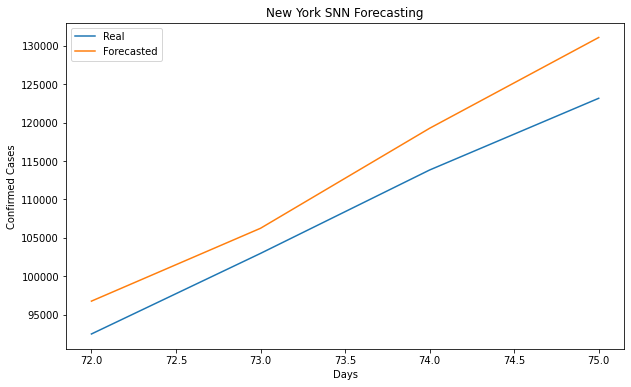

In [54]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
  

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]
print(forecast)

plt.figure(figsize=(10, 6))
plt.title("New York SNN Forecasting")
plt.ylabel("Confirmed Cases")
plt.xlabel("Days")

plt.plot( time_valid, x_valid,label="Real")
plt.plot(time_valid, results,label="Forecasted")
plt.legend()

Bidirectional LSTM forecasting

In [55]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, return_sequences=True,activation="relu")),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50,activation="relu")),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss=tf.keras.losses.Huber(), optimizer="adam",metrics=["mae"])
history = model.fit(dataset,epochs=1000)

Epoch 1/1000
23/23 [==============================] - 0s 9ms/step - loss: 5941.0342 - mae: 5941.2769
Epoch 2/1000
23/23 [==============================] - 0s 8ms/step - loss: 3017.0659 - mae: 3017.3845
Epoch 3/1000
23/23 [==============================] - 0s 9ms/step - loss: 1176.1954 - mae: 1176.4336
Epoch 4/1000
23/23 [==============================] - 0s 8ms/step - loss: 1954.8517 - mae: 1955.1263
Epoch 5/1000
23/23 [==============================] - 0s 9ms/step - loss: 1507.8171 - mae: 1508.0575
Epoch 6/1000
23/23 [==============================] - 0s 8ms/step - loss: 1363.9036 - mae: 1364.1294
Epoch 7/1000
23/23 [==============================] - 0s 8ms/step - loss: 1339.6345 - mae: 1339.8833
Epoch 8/1000
23/23 [==============================] - 0s 9ms/step - loss: 1385.3492 - mae: 1385.5927
Epoch 9/1000
23/23 [==============================] - 0s 10ms/step - loss: 2512.4380 - mae: 2512.7021
Epoch 10/1000
23/23 [==============================] - 0s 9ms/step - loss: 1329.4946 - mae

[array([[96339.766]], dtype=float32), array([[105789.37]], dtype=float32), array([[118604.43]], dtype=float32), array([[130403.65]], dtype=float32)]


Text(0.5, 0, 'Days')

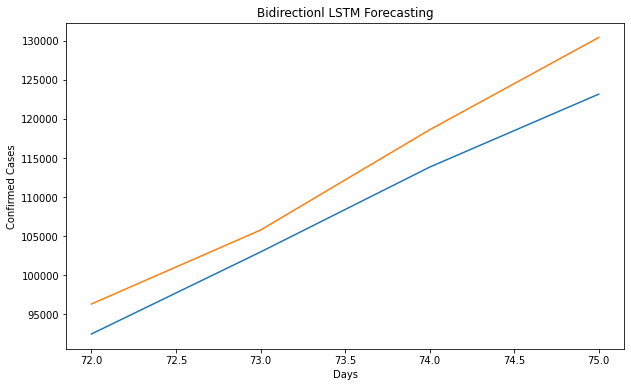

In [56]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]
print(forecast)

plt.figure(figsize=(10, 6))

plt.plot( time_valid, x_valid,label="Real")
plt.plot(time_valid, results,label="Forecasted")
plt.title("Bidirectionl LSTM Forecasting")
plt.ylabel("Confirmed Cases")
plt.xlabel("Days")

Bidirectional LSTM seems to give most accurate results on validation set. This neural network will be trained with full train set and then will be used to forecast on test set

In [0]:
test_df=pd.read_csv("test.csv")

In [102]:
test_df.shape

(13158, 4)

In [103]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13158 entries, 0 to 13157
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ForecastId      13158 non-null  int64 
 1   Province_State  5590 non-null   object
 2   Country_Region  13158 non-null  object
 3   Date            13158 non-null  object
dtypes: int64(1), object(3)
memory usage: 411.3+ KB


In [0]:
test_df=test_df[test_df["Province_State"]=="New York"]

In [105]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43 entries, 11395 to 11437
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ForecastId      43 non-null     int64 
 1   Province_State  43 non-null     object
 2   Country_Region  43 non-null     object
 3   Date            43 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.7+ KB


In [0]:
days_df = pd.DataFrame()

In [0]:
days_df["days_test"]=[x for x in range(1,85)]

In [0]:
test_df1=train_df.reset_index()
days_df1=days_df.reset_index()


In [0]:
list_df = [test_df1, days_df]
test_df_final = pd.concat(list_df, axis=1)

In [122]:
test_df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           75 non-null     float64
 1   Id              75 non-null     float64
 2   Province_State  75 non-null     object 
 3   Country_Region  75 non-null     object 
 4   Date            75 non-null     object 
 5   ConfirmedCases  75 non-null     float64
 6   Fatalities      75 non-null     float64
 7   days            75 non-null     float64
 8   days_test       84 non-null     int64  
dtypes: float64(5), int64(1), object(3)
memory usage: 6.0+ KB


In [123]:
test_df_final.tail(20)

,index,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,days,days_test
64,19939.0,28420.0,New York,US,2020-03-26,37877.0,385.0,65.0,65
65,19940.0,28421.0,New York,US,2020-03-27,44876.0,527.0,66.0,66
66,19941.0,28422.0,New York,US,2020-03-28,52410.0,728.0,67.0,67
67,19942.0,28423.0,New York,US,2020-03-29,59648.0,965.0,68.0,68
68,19943.0,28424.0,New York,US,2020-03-30,66663.0,1218.0,69.0,69
69,19944.0,28425.0,New York,US,2020-03-31,75833.0,1550.0,70.0,70
70,19945.0,28426.0,New York,US,2020-04-01,83948.0,1941.0,71.0,71
71,19946.0,28427.0,New York,US,2020-04-02,92506.0,2373.0,72.0,72
72,19947.0,28428.0,New York,US,2020-04-03,102987.0,2935.0,73.0,73
73,19948.0,28429.0,New York,US,2020-04-04,113833.0,3565.0,74.0,74


In [0]:
x=test_df_final.iloc[:,2]
time=test_df_final.iloc[:,8]
y=test_df_final.iloc[:,5]
time=time.to_numpy(dtype="float32")
series=y.to_numpy(dtype="float32")

In [0]:
time=np.array(time)
series=np.array(series)
split_time = 72
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [0]:
window_size = 2
batch_size = 3
shuffle_buffer_size = 74

In [127]:
print(series)

[     0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.    173.    220.    328.    421.    525.    732.
    967.   1706.   2495.   5365.   8310.  11710.  15800.  20884.  25681.
  30841.  37877.  44876.  52410.  59648.  66663.  75833.  83948.  92506.
 102987. 113833. 123160.     nan     nan     nan     nan     nan     nan
     nan     nan     nan]


0
[[-0.07464886]]
1
[[-0.07464886]]
2
[[-0.07464886]]
3
[[-0.07464886]]
4
[[-0.07464886]]
5
[[-0.07464886]]
6
[[-0.07464886]]
7
[[-0.07464886]]
8
[[-0.07464886]]
9
[[-0.07464886]]
10
[[-0.07464886]]
11
[[-0.07464886]]
12
[[-0.07464886]]
13
[[-0.07464886]]
14
[[-0.07464886]]
15
[[-0.07464886]]
16
[[-0.07464886]]
17
[[-0.07464886]]
18
[[-0.07464886]]
19
[[-0.07464886]]
20
[[-0.07464886]]
21
[[-0.07464886]]
22
[[-0.07464886]]
23
[[-0.07464886]]
24
[[-0.07464886]]
25
[[-0.07464886]]
26
[[-0.07464886]]
27
[[-0.07464886]]
28
[[-0.07464886]]
29
[[-0.07464886]]
30
[[-0.07464886]]
31
[[-0.07464886]]
32
[[-0.07464886]]
33
[[-0.07464886]]
34
[[-0.07464886]]
35
[[-0.07464886]]
36
[[-0.07464886]]
37
[[-0.07464886]]
38
[[-0.07464886]]
39
[[-0.07464886]]
40
[[-0.07464886]]
41
[[-0.07464886]]
42
[[-0.07464886]]
43
[[-0.07464886]]
44
[[-0.07464886]]
45
[[-0.07464886]]
46
[[-0.07464886]]
47
[[223.55428]]
48
[[343.5174]]
49
[[517.2469]]
50
[[649.1376]]
51
[[818.3521]]
52
[[1170.087]]
53
[[1478.0032]]
54


Text(0.5, 0, 'Days')

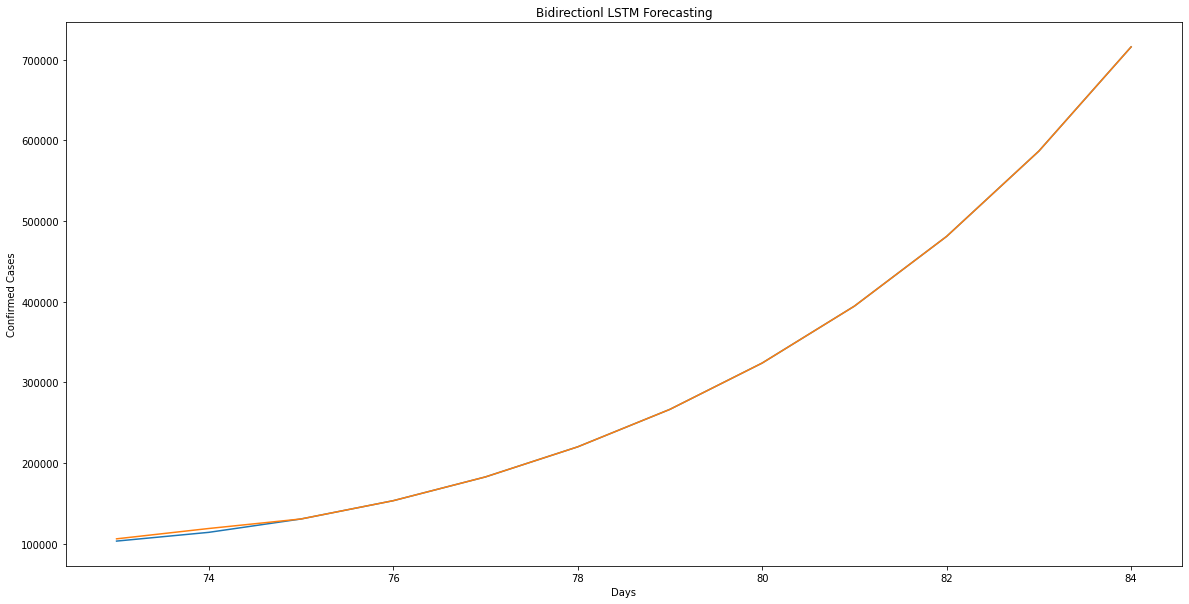

In [128]:
forecast=[]
for time in range(len(series) - window_size):
    print(time)
    z=model.predict(series[time:time + window_size][np.newaxis])
    print(z)
    if time >= 72:
        series[time+window_size]=z
        print(series)
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
 
  


forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(20, 10))

plt.plot( time_valid, x_valid,label="Real")
plt.plot(time_valid, results,label="Forecasted")
plt.title("Bidirectionl LSTM Forecasting")
plt.ylabel("Confirmed Cases")
plt.xlabel("Days")

In [129]:
print(forecast)

[array([[105789.37]], dtype=float32), array([[118604.43]], dtype=float32), array([[130403.65]], dtype=float32), array([[153079.81]], dtype=float32), array([[182555.89]], dtype=float32), array([[219848.39]], dtype=float32), array([[266322.3]], dtype=float32), array([[323734.66]], dtype=float32), array([[394296.5]], dtype=float32), array([[480754.84]], dtype=float32), array([[586497.06]], dtype=float32), array([[715681.8]], dtype=float32)]
